Cell 1 – Setup imports + project root

In [42]:
# 02_embeddings_clustering.ipynb

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import hdbscan
from sklearn.preprocessing import normalize

from sklearn.cluster import KMeans

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.config import load_config
from src.data.loader import load_jobs
from src.embeddings.embedder import embed_texts, build_and_save_embeddings
from src.evaluation.metrics import internal_cluster_metrics
from src.clustering.clustering import kmeans_clusters, hdbscan_clusters, agglomerative_clusters
from src.data.preprocess import build_embed_text
from sentence_transformers import SentenceTransformer


sns.set(style="whitegrid")

cfg = load_config()
TEXT_COL = cfg["jobs"]["text_column"]

LABELS_PATH = PROJECT_ROOT / "results" / "clusters" / "kmeans_labels.npy"
EMB_PATH = PROJECT_ROOT / "results" / "embeddings" / "embeddings_desc_clean_len50.npy"

cfg


{'database': {'host': 'localhost',
  'port': 5432,
  'user': 'admin',
  'password': 'admin',
  'dbname': 'labor_db'},
 'jobs': {'table_name': 'job_postings',
  'text_column': 'description',
  'id_column': 'company_id'},
 'embeddings': {'model_name': 'sentence-transformers/all-MiniLM-L6-v2',
  'batch_size': 64,
  'device': 'cpu'},
 'clustering': {'n_clusters': 100, 'min_cluster_size': 100},
 'taxonomy': {'onet_path': '../data/onet_occupations.csv',
  'title_column': 'Title',
  'desc_column': 'Description',
  'code_column': 'O*NET-SOC Code',
  'top_k': 3,
  'similarity_threshold': 0.4}}

In [44]:
print("Using EMB_PATH =", EMB_PATH.resolve())


Using EMB_PATH = C:\Users\hisuk\labor-market-nlp-prototype\results\embeddings\embeddings_desc_clean_len50.npy


Cell 2 – Load jobs & build embeddings (or reuse cached)

In [45]:
jobs = load_jobs()
print("Jobs shape:", jobs.shape)


# 1) Clean + filter 
clean_texts = (
    jobs["description"]
    .fillna("")
    .astype(str)
    .str.replace(r"<[^>]+>", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

mask = clean_texts.str.len() > 50
jobs = jobs.loc[mask].reset_index(drop=True)
texts = clean_texts.loc[mask].tolist()

print("After filtering:", jobs.shape)

# 2) cache path -> 'clean+len50'
EMB_PATH.parent.mkdir(parents=True, exist_ok=True)

if EMB_PATH.exists():
    print("Loading cached embeddings from:", EMB_PATH)
    embeddings = np.load(EMB_PATH)
    
    if embeddings.shape[0] != len(jobs):
        print("Cache mismatch → rebuilding embeddings")
        embeddings = build_and_save_embeddings(jobs, EMB_PATH, texts=texts)
else:
    print("Building embeddings (cleaned description)…")
    embeddings = build_and_save_embeddings(jobs, EMB_PATH, texts=texts)

print("Embeddings shape:", embeddings.shape)




Jobs shape: (24164, 15)
After filtering: (24001, 15)
Building embeddings (cleaned description)…


Batches: 100%|██████████| 376/376 [15:25<00:00,  2.46s/it]


Embeddings shape: (24001, 384)


In [ ]:
# embeddings -> L2 normalized
km_labels = kmeans_clusters(embeddings)

jobs_with_labels = jobs.copy()
jobs_with_labels["cluster"] = km_labels
np.save(LABELS_PATH, km_labels)


print("Noise ratio:", float((km_labels == -1).mean()))
print("Number of clusters:", int(len(set(km_labels)) - (1 if -1 in km_labels else 0)))



Noise ratio: 0.0
Number of clusters: 100


Cell 3 – 

In [30]:
jobs_with_labels = jobs.copy()
jobs_with_labels["cluster"] = km_labels

jobs_with_labels["speciality_clean"] = jobs_with_labels["speciality"].fillna("Unknown")

top3 = (
    jobs_with_labels
    .groupby("cluster")["speciality_clean"]
    .value_counts()
    .groupby(level=0)
    .head(3)
)
top3


cluster  speciality_clean  
0        Unknown               58
         Dermatology            6
         Medical Device         5
1        Unknown               45
         Construction           3
                               ..
98       IT Consulting         13
         IT Staffing            9
99       Unknown               36
         Financial Services     6
         Payments               5
Name: count, Length: 300, dtype: int64

Cell 4 – Cluster size distribution

In [31]:
cluster_sizes = pd.Series(km_labels).value_counts().sort_index()
cluster_sizes


0     187
1     208
2     279
3     196
4     434
     ... 
95    240
96    215
97    105
98    477
99    195
Name: count, Length: 100, dtype: int64

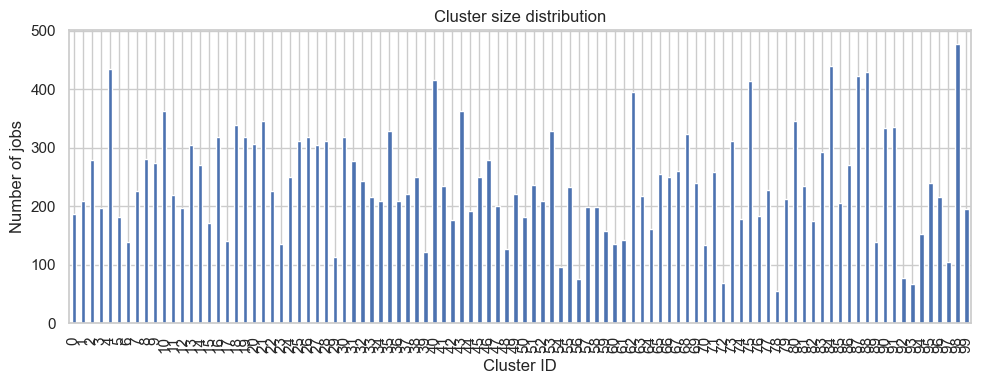

In [ ]:
plt.figure(figsize=(10, 4))
cluster_sizes.plot(kind="bar")
plt.title("Cluster size distribution"
plt.xlabel("Cluster ID")
plt.ylabel("Number of jobs")
plt.tight_layout()
plt.show()


Cell 5 – Internal cluster metrics

In [33]:
metrics = internal_cluster_metrics(embeddings, km_labels)
metrics

{'silhouette': 0.03062870353460312,
 'davies_bouldin': 4.476163984919504,
 'n_clusters': 100}

Cell 6 – Attach labels back to jobs and inspect

In [49]:
jobs_with_labels = jobs.copy()
jobs_with_labels["cluster"] = km_labels

jobs_with_labels.head()

out_path = PROJECT_ROOT / "data" / "jobs_with_clusters.parquet"
out_path.parent.mkdir(parents=True, exist_ok=True)

jobs_with_labels.to_parquet(out_path, index=False)
print("Saved to:", out_path)

Saved to: C:\Users\hisuk\labor-market-nlp-prototype\data\jobs_with_clusters.parquet


In [35]:
# Look at a few clusters and their most common job titles
jobs_with_labels.groupby("cluster")["speciality"].value_counts().groupby(level=0).head(3)


cluster  speciality             
0        Dermatology                6
         Medical Device             5
         Laser Hair Removal         3
1        Construction               3
         Natural Gas                3
                                   ..
98       IT Staffing                9
         Application Development    7
99       Financial Services         6
         Payments                   5
         Mobile Payments            3
Name: count, Length: 300, dtype: int64

Cell 7 – Inspect a single cluster in detail

In [50]:
cluster_id = 0  # change as you like
cluster_sample = jobs_with_labels[jobs_with_labels["cluster"] == cluster_id].head(10)
cluster_sample[[cfg["jobs"]["id_column"], "speciality", "name", TEXT_COL]]


,company_id,speciality,name,description
823,9060,Airway Management,Laerdal Medical,Laerdal Medical is a world leader in healthcar...
877,165340,Regenerative Medicine,Organogenesis,Organogenesis™ is a leading regenerative medic...
1438,9561,Robotics,Intuitive,"Intuitive (Nasdaq: ISRG), headquartered in Sun..."
1624,11073,audiology,Starkey Hearing,"Starkey is a privately held, global hearing te..."
1737,58360388,None,Sandstone Medical Solutions,Sandstone Medical Solutions is a professional ...
1956,14376,Design,KARL STORZ United States,KARL STORZ United States is a leader in endosc...
2006,15022,Medical devices,"FUJIFILM Sonosite, Inc.","As an innovator in point-of-care ultrasound, w..."
2010,15038,Ergonomic Seating,Humanscale,Humanscale is the premier designer and manufac...
2026,15217,Airway Management,Ambu A/S,Innovations that make a difference \n\nEver s...
2067,15602,Cardiovascular Medical Device Manufacturer,Abiomed,"Based in Danvers, Massachusetts, USA, Abiomed,..."
